## Imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt

from monai.inferers import sliding_window_inference
from monai.config import print_config


import torch
#import pytorch_lightning
import lightning
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from monai_unet import Net


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)
torch.backends.cudnn.benchmark = True

device =  cuda


In [9]:
PATH = "C:\\awilde\\britta\\LTU\\DataMining\\Data\\Task01_BrainTumour\\"

## Run the training

In [3]:
torch.set_float32_matmul_precision('medium')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
# initialise the LightningModule
net = Net(device=device, datadir= PATH, in_channels=4, out_channels=4, augmentation=False)

# set up checkpoints
# TODO model callback set when val_loss lowest
checkpoint_callback = ModelCheckpoint(dirpath="./heart_data_lightning_models/", filename='{epoch}-{val_loss:.2f}-{val_dice:.2f}', monitor="val_dice", mode="max")
early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
max_epochs = 10

# initialise Lightning's trainer.
trainer = lightning.Trainer(
    devices=[0],
    max_epochs=max_epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=4,
)

# train
trainer.fit(net)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\awilde\britta\LTU\DataMining\DataMiningProjectWork\heart_data_lightning_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.72it/s]current epoch: 0 current val_loss: 32.126953125 current mean dice: 0.0155
best mean dice: 0.0155 at epoch: 0
Epoch 0: 100%|██████████| 387/387 [00:27<00:00, 13.89it/s, v_num=12]       current epoch: 0 current val_loss: 1.1520357131958008 current mean dice: 0.0633
best mean dice: 0.0633 at epoch: 0
Epoch 1: 100%|██████████| 387/387 [00:11<00:00, 33.80it/s, v_num=12]current epoch: 1 current val_loss: 0.8702502250671387 current mean dice: 0.1189
best mean dice: 0.1189 at epoch: 1
Epoch 2: 100%|██████████| 387/387 [00:12<00:00, 31.60it/s, v_num=12]current epoch: 2 current val_loss: 0.8975085616111755 current mean dice: 0.1332
best mean dice: 0.1332 at epoch: 2
Epoch 3: 100%|██████████| 387/387 [00:12<00:00, 30.16it/s, v_num=12]current epoch: 3 current val_loss: 0.7623852491378784 current mean dice: 0.1842
best mean dice: 0.1842 at epoch: 3
Epoch 4: 100%|██████████| 387/387 [00:22<00:00, 17.29it/s, v_num=12]current e

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 387/387 [00:12<00:00, 30.14it/s, v_num=12]


## Plot the loss and dice metric

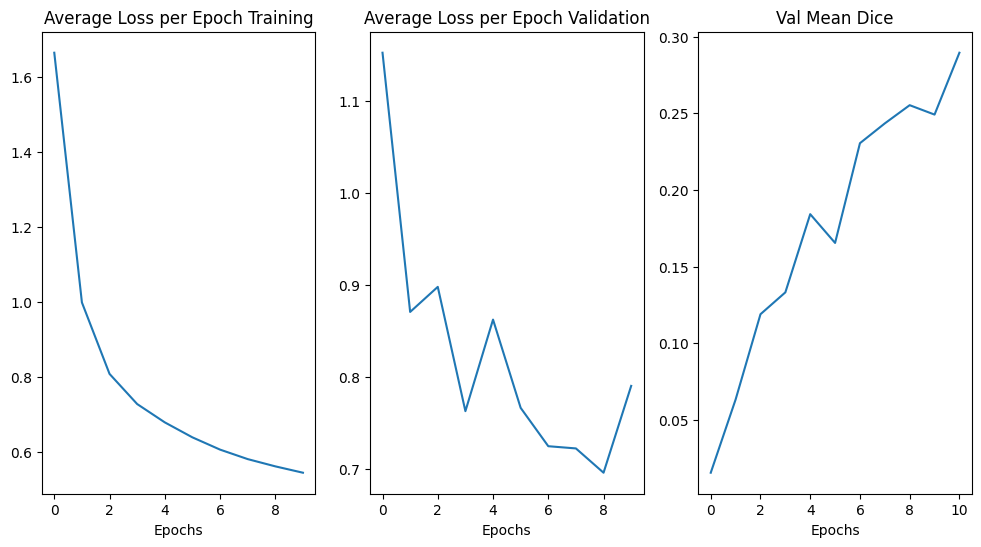

In [6]:
plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Average Loss per Epoch Training")
x = [i for i in range(0,len(net.epoch_train_loss))]
y = net.epoch_train_loss
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 2)
plt.title("Average Loss per Epoch Validation")
# skip first epoch for validation loss as it is very high
x = [i for i in range(0,len(net.epoch_val_loss)-1)]
y = net.epoch_val_loss[1:]
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice")
x = [i for i in range(0,len(net.metric_values))]
y = net.metric_values
plt.xlabel("Epochs")
plt.plot(x, y)
plt.show()

## Test model on unseen data

In [7]:
# this will print the avg loss and dice metric on the test set
trainer.test()

c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Loading dataset: 100%|██████████| 49/49 [00:53<00:00,  1.09s/it]
Restoring states from the checkpoint path at C:\awilde\britta\LTU\DataMining\DataMiningProjectWork\heart_data_lightning_models\epoch=9-val_loss=0.79-val_dice=0.29.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\awilde\britta\LTU\DataMining\DataMiningProjectWork\heart_data_lightning_models\epoch=9-val_loss=0.79-val_dice=0.29.ckpt


Testing DataLoader 0: 100%|██████████| 49/49 [00:01<00:00, 35.31it/s]


[{}]

## Load model from checkpoint to plot predictions

In [12]:
model = Net.load_from_checkpoint(checkpoint_callback.best_model_path, device = device, in_channels=4, out_channels=4, augmentation=False, datadir = PATH)
model.eval()
model.to(device)
model.prepare_data()

c:\awilde\britta\LTU\DataMining\DataMiningProjectWork\.conda\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 49/49 [00:50<00:00,  1.04s/it]


In [14]:
# make predictions
images = []
outputs = []
labels = []
val_loader = model.test_dataloader()
#TODO only make predictions for some images?
i = 0
for val_data in val_loader: 
    if i ==2:
        break
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )
    images.append(val_inputs)
    outputs.append(model.forward(val_inputs))
    labels.append(val_labels)
    i += 1

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def plot_predictions(idx_of_image, outputs, images, labels):
    # Assuming outputs, labels, and images are your variables
    output = outputs[idx_of_image]
    label = labels[idx_of_image][0][0]
    image = images[idx_of_image][0][0]

    # Set the slice range from 45 to 50
    slice_start = 45
    slice_end = 55

    # Calculate the number of slices
    num_slices = slice_end - slice_start

    # Create a subplot with 'num_slices' rows and 3 columns
    plt.figure(figsize=(15, 5 * num_slices))

    for i in range(num_slices):
        # Increment the slice index
        current_slice = slice_start + i
        
        # Plot the Model Output
        plt.subplot(num_slices, 3, 3 * i + 1)
        with torch.no_grad():
            plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
        plt.title(f'Model Output - Slice {current_slice}')

        # Plot the Label
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.imshow(label.cpu()[:, :, current_slice])
        plt.title(f'Label - Slice {current_slice}')

        # Plot the Input Image
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.imshow(image.cpu()[:, :, current_slice])
        plt.title(f'Input Image - Slice {current_slice}')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

## Plot predictions

In [ ]:
plot_predictions(0, outputs, images, labels)